In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from recovery_factor.preprocess import clean, split
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

In [2]:
data_commercial = pd.read_csv(Path("..") / "data/Commercial-focused.csv")
data_atlas = pd.read_excel(
    Path("..") / "data/2018 Atlas Update.xlsx", usecols=["POROSITY", "PERMEABILITY", "ORF"]
)

In [3]:
data_toris = pd.read_csv(Path("../data/TORIS-explore.csv"))

In [4]:
data = pd.concat(
    [
        data_atlas.rename(columns={"ORF": "RF"}).assign(DATABASE="Atlas")[lambda x: x.RF > 0],
        data_commercial.assign(
            DATABASE="Commercial", POROSITY=lambda x: x.POROSITY / 100.0, RF=lambda x: x.RF / 100.0
        ),
        data_toris.assign(DATABASE="TORIS", POROSITY=lambda x: x.POROSITY / 100.0),
    ]
).reset_index(drop=True)

In [5]:
data.groupby("DATABASE")[["POROSITY", "PERMEABILITY", "RF"]].describe().T

DATABASE                  Atlas    Commercial         TORIS
POROSITY     count  4545.000000   1256.000000   1337.000000
             mean      0.286667      0.185283      0.194829
             std       0.033411      0.078679      0.094112
             min       0.100000      0.010000      0.001000
             25%       0.270000      0.130000      0.120000
             50%       0.290000      0.180000      0.190000
             75%       0.310000      0.240000      0.280000
             max       0.380000      0.580000      0.580000
PERMEABILITY count  4505.000000   1190.000000   1275.000000
             mean    442.475028    551.939865    469.558431
             std     472.172806   1840.422509   1132.431201
             min       0.000000      0.000000      0.000000
             25%     136.000000     13.000000     20.000000
             50%     278.000000    100.000000    122.000000
             75%     576.000000    460.750000    500.000000
             max    3898.000000  50000.000000  26817.000000
RF           count  4545.000000    769.000000    831.000000
             mean      0.312680      0.373256      0.173767
             std       0.167733      0.156859      0.147524
             min       0.010000      0.020000      0.000000
             25%       0.180000      0.270000      0.055000
             50%       0.320000      0.360000      0.140000
             75%       0.440000      0.480000      0.260000
             max       2.320000      0.900000      0.850000

In [6]:
data.to_parquet("../data/combined_exploration.parquet")

In [7]:
data = pd.read_parquet("../data/combined_exploration.parquet").assign(
    LOG_PERMEABILITY=lambda x: np.log(x.PERMEABILITY)
)

/home/frank/Dropbox/ROZ/code/Estimating-oil-recovery-factor-at-exploration-stage-using-XGBoost-classification-/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


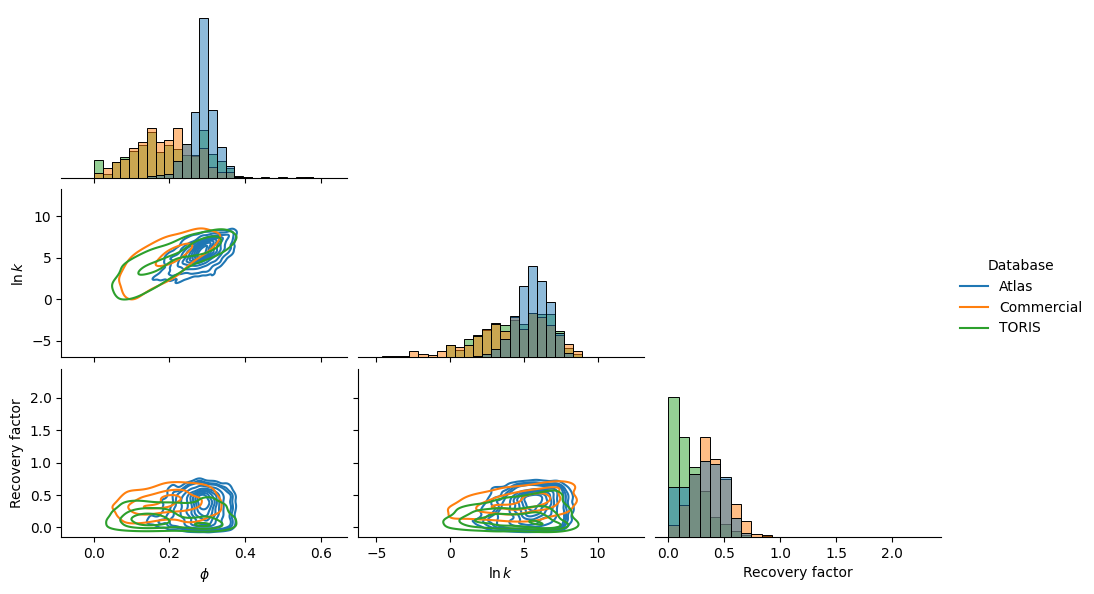

In [8]:
data_plot = data.rename(
    columns={
        "POROSITY": "$\phi$",
        "LOG_PERMEABILITY": "$\ln k$",
        "RF": "Recovery factor",
        "DATABASE": "Database",
    }
)
plot_vars = ["$\phi$", "$\ln k$", "Recovery factor"]

# g = sns.pairplot(data, vars=["POROSITY","LOG_PERMEABILITY","RF"], hue="DATABASE", diag_kind="hist", kind="kde", aspect=1.61, diag_kws={"stat":"probability", "common_norm":False, "bins":25}, corner=True)
g = sns.pairplot(
    data_plot,
    vars=plot_vars,
    hue="Database",
    diag_kind="hist",
    kind="kde",
    aspect=1.61,
    diag_kws={"stat": "probability", "common_norm": False, "bins": 25},
    corner=True,
    height=2,
)

g.savefig("distributions-fig1.png", bbox_inches="tight", dpi=200)

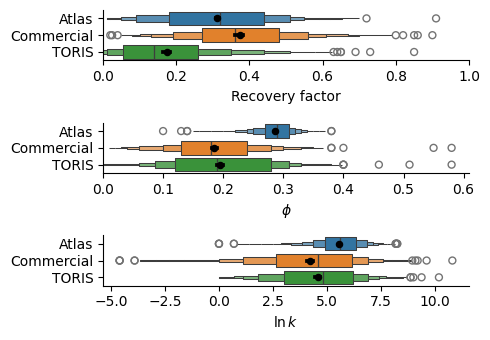

In [9]:
fig, (ax_rf, ax_phi, ax_k) = plt.subplots(3, 1, figsize=(5, 3.5))

sns.boxenplot(data_plot, x="Recovery factor", y="Database", hue="Database", ax=ax_rf)
sns.pointplot(
    data_plot,
    x="Recovery factor",
    y="Database",
    ax=ax_rf,
    color="k",
    markers=".",
    linestyle="none",
)
ax_rf.set(ylabel="", xlim=(0, 1))

sns.boxenplot(data_plot, x="$\phi$", y="Database", hue="Database", ax=ax_phi)
sns.pointplot(
    data_plot, x="$\phi$", y="Database", ax=ax_phi, color="k", markers=".", linestyle="none"
)
ax_phi.set(ylabel="", xlim=(0, None))

sns.boxenplot(data_plot, x="$\ln k$", y="Database", hue="Database", ax=ax_k)
sns.pointplot(
    data_plot, x="$\ln k$", y="Database", ax=ax_k, color="k", markers=".", linestyle="none"
)
ax_k.set(ylabel="")
fig.tight_layout()
sns.despine()

fig.savefig("letter-value-plot-fig2.png", dpi=200, bbox_inches="tight")

In [10]:
data_root = Path("../data_run")
# [f.name for f in data_root.glob("*.csv")]
full_data = pd.concat(
    [pd.read_csv(file).assign(db=file.name.split(".")[0]) for file in data_root.glob("*.csv")]
).pipe(clean)

In [15]:
full_data.columns

Index(['API GRAVITY', 'FVF', 'GOR', 'WATER SATURATION', 'TEMPERATURE',
       'PRESSURE', 'THICKNESS', 'RESERVES', 'PERMEABILITY', 'POROSITY', 'AREA',
       'RECOVERY FACTOR', 'Class', 'db'],
      dtype='object')

In [20]:
full_data.drop(columns="Class").groupby("db").agg(["min", "max"]).T.style.format("{:.2f}")

/tmp/ipykernel_3289374/3183382864.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  full_data.drop(columns="Class").groupby("db").agg(["min","max"]).T.style.format("{:.2f}")


In [25]:
full_data.groupby("db")["RECOVERY FACTOR"].agg(["min", "max"])

/tmp/ipykernel_3289374/1727362899.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  full_data.groupby("db")["RECOVERY FACTOR"].agg(["min","max"])


,min,max
db,,
CA,0.01,0.91
TA,0.01,1.00
TC,0.02,1.00
TCA,0.01,1.00
